[Back to the starting page](start.ipynb)

In [1]:
import numpy as np
import os
from scripts import *
from copy import deepcopy
path = './data/thermodyn/'

In [2]:
# Build grids from given mantle composition
# using ouputs from perplex
# 
# Already done for all compositions shown below. 
# Only data for the composition 'slm_sp2008' is on github and accessible from Binder, the rest is on figshare
#

# Compositions (see manupscript for details)

# Depleted mantle
#name = 'mg93_low_al2o3_low_na2o_Cr'
#name = 'mg93_high_al2o3_high_na2o_Cr'
#name = 'mg89_low_al2o3_low_na2o_Cr'
#name = 'ylm3'
#name = 'ylm2'
#name = 'plm1'
#name = 'plm2'
#name = 'alm0'
#name = 'alm1'
#name = 'alm2'

# Fertile manlte composition
#name = 'slm_klb1'
#name = 'slm_ms'
#name = 'slm_j79'
name = 'slm_sp2008'   # = 'mg89_high_al2o3_high_na2o_Cr'
                      # slm    = sub-lithospheric mantle
                      # sp2008 = Simon and Podladchikov, 2008 

# Computations with perplex are splitted into HP-HT, HP-LT and LP pressure-temperature fields
# for stability and convergence reasons.
#
# Below we merge the different outputs from Perplex into one grid.
#

# 1) Build HP grid
pmin      = 0.5e9 # Pa
pmax      = 6.0e9 # Pa
path_used = path+name

if ( os.path.isfile(path_used+'/'+name+'.bin') ):
    print("The grid {}.bin is already constructed.".format(name))
else:
    print("Building grid for mantle composition {}".format(name))
    if ( os.path.isfile(path_used+'/'+name+'_HP-HT.phm') and os.path.isfile(path_used+'/'+name+'_HP-LT.phm') ):
        print("Read HP-HT data...")
        # HP-HT
        perplex_HP_HT = geodyn1d.thermodyn.read_output_from_perple_x(name+'_HP-HT',path=path_used)
        geodyn1d.thermodyn.remove_outliers_from_perplex(perplex_HP_HT,window=None)
        geodyn1d.thermodyn.remove_NaN_values_from_perplex(perplex_HP_HT)
        print("Read HP-LT data...")
        # HP-LT
        perplex_HP_LT = geodyn1d.thermodyn.read_output_from_perple_x(name+'_HP-LT',path=path_used)
        geodyn1d.thermodyn.remove_outliers_from_perplex(perplex_HP_LT)   # local wrong numerical solution
        geodyn1d.thermodyn.remove_NaN_values_from_perplex(perplex_HP_LT)

        perplex_HP = geodyn1d.thermodyn.merge_perplex(
            perplex_HP_HT,perplex_HP_LT,
            plim=[pmin,pmax],
            nt_used=None,np_used=None)

    # 2) Build final grid
    pmax     = 22.0e9
    nt_used  = 100
    np_used  = 200

    # Possibility of removing local outliers (wrong numerical convergence) by defining a window [T1,T2,P1,P2]
    window_outliers    = None
    window_outliers2   = None

    if ( os.path.isfile(path_used+'/'+name+'_LP.phm') ):
        print("Read LP data...")
        # LP
        perplex_LP = geodyn1d.thermodyn.read_output_from_perple_x(name+'_LP',path=path_used)
        geodyn1d.thermodyn.remove_outliers_from_perplex(perplex_LP,window=window_outliers)
        geodyn1d.thermodyn.remove_NaN_values_from_perplex(perplex_LP)
    else:
        perplex_LP = perplex_HP
        print('No LP file')

    print("Merge HP and LP data...")
    perplex_LP_HP = geodyn1d.thermodyn.merge_perplex(perplex_HP,perplex_LP,
                                                     plim=[0,pmax],
                                                     nt_used=nt_used,np_used=np_used,
                                                     method='cubic')

    print("Extrapolation at LT and HP...")
    perplex_LP_HP_lowT             = geodyn1d.thermodyn.extrapolate_lowT_perplex2(perplex_LP_HP)
    perplex_LP_HP_lowT_highT       = geodyn1d.thermodyn.extrapolate_highT_perplex(perplex_LP_HP_lowT)
    perplex_LP_HP_lowT_highT_highP = geodyn1d.thermodyn.extrapolate_highP_perplex(perplex_LP_HP_lowT_highT)
    
    if ( window_outliers2 is not None ):
        geodyn1d.thermodyn.remove_outliers_from_perplex(perplex_LP_HP_lowT_highT_highP,window=window_outliers2)
        perplex_LP_HP_lowT_highT_highP = geodyn1d.thermodyn.merge_perplex(perplex_LP_HP_lowT_highT_highP,perplex_LP_HP_lowT_highT_highP,plim=[0,pmax],nt_used=nt_used,np_used=np_used)

    # Remove NaN values if present and mask unmelted domain
    geodyn1d.thermodyn.check_melt_from_perplex(perplex_LP_HP_lowT_highT_highP)

    print("Write final grid binary file...")
    # Write binary files
    geodyn1d.thermodyn.write_binary_file_perplex(perplex_LP_HP_lowT_highT_highP,name,path=path_used)
    print("Done!")

    # binary file for fortran code (Fantom)
    #geodyn1d.thermodyn.write_binary_fortran_file_perplex(perplex_LP_HP_lowT_highT_highP,name,path=path_used)


Building grid for mantle composition slm_sp2008
Read HP-HT data...
Pmin 500000000.0 dP 55555555.55555555 Tmin 873.0 dT 10.606060606060606 
Pmin 500000000.0 Pmax 6000000000.0 Tmin 873.0 Tmax 1923.0 
Read HP-LT data...
Pmin 500000000.0 dP 55555555.55555555 Tmin 473.0 dT 4.040404040404041 
Pmin 500000000.0 Pmax 6000000000.0 Tmin 473.0 Tmax 873.0 
Read LP data...
Pmin 0.0 dP 5050505.05050505 Tmin 473.0 dT 15.151515151515152 
Pmin 0.0 Pmax 500000000.0 Tmin 473.0 Tmax 1973.0 
Merge HP and LP data...
Extrapolation at LT and HP...
Write final grid binary file...
Done!


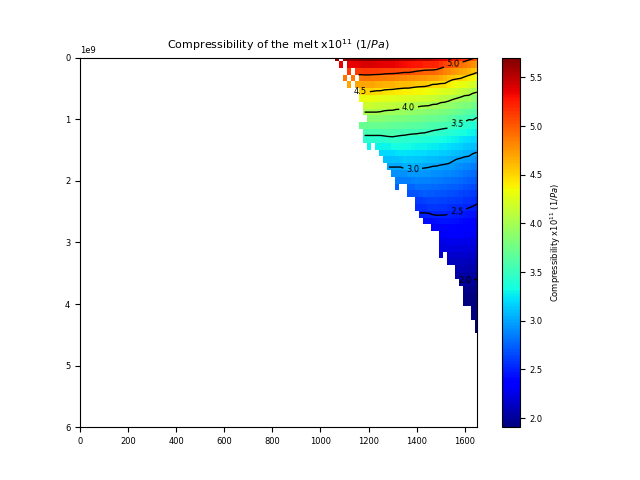

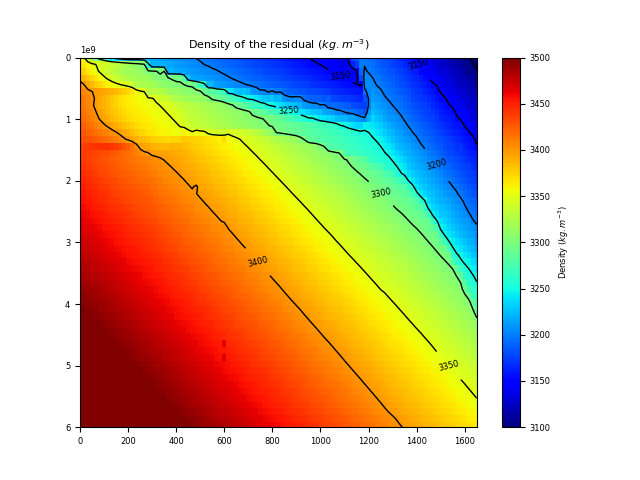

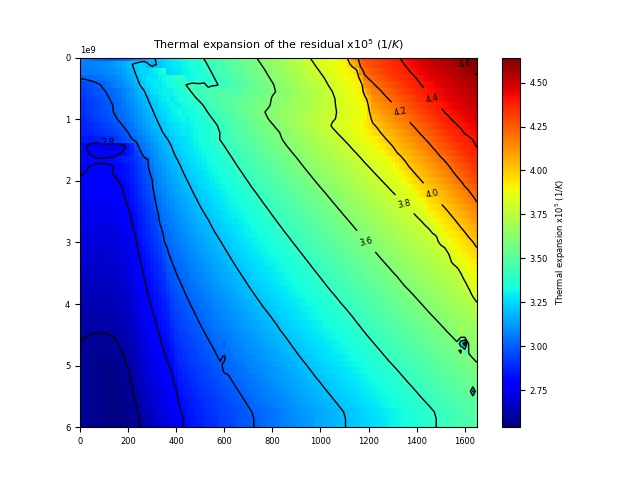

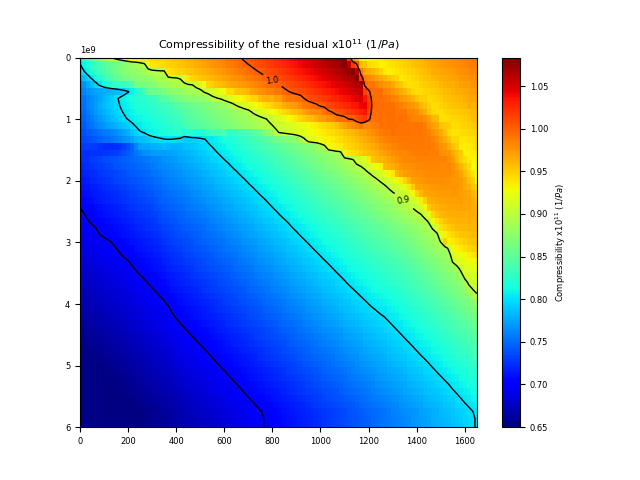

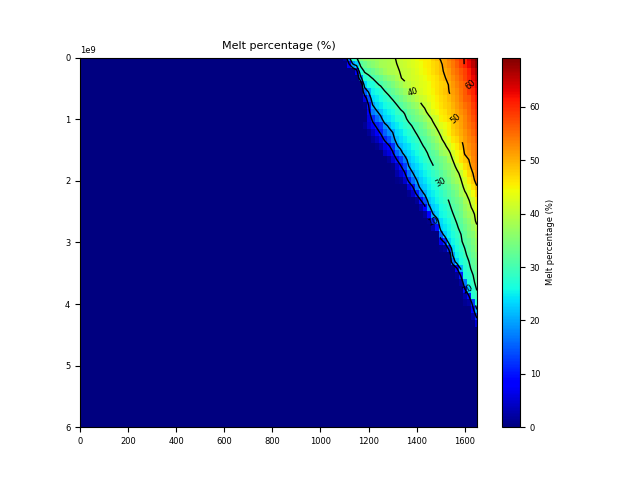

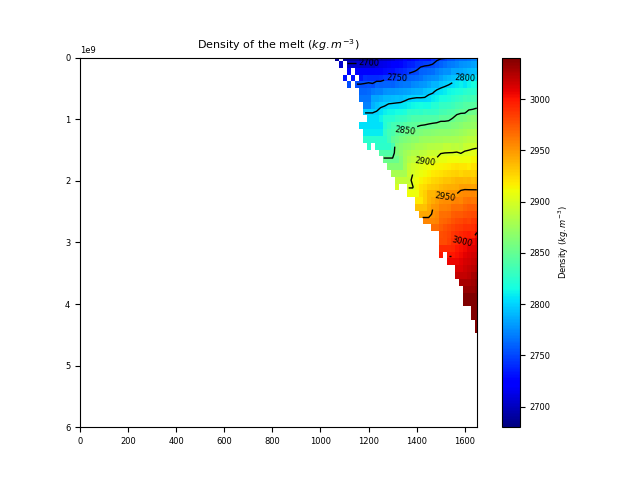

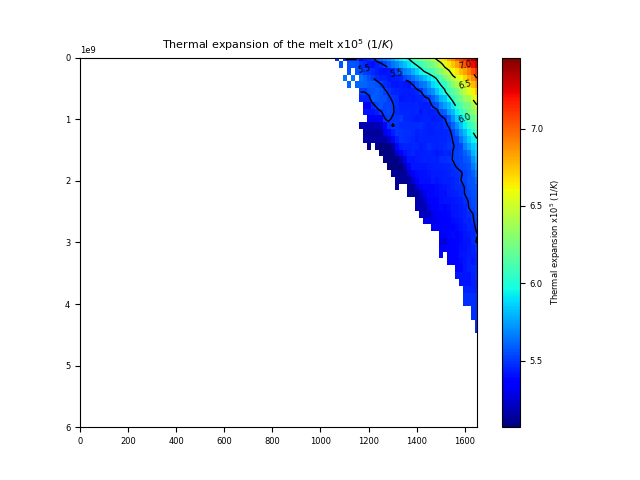

In [3]:
# Plotting P-T maps

# Depleted mantle
#name = 'mg93_low_al2o3_low_na2o_Cr'
#name = 'mg93_high_al2o3_high_na2o_Cr'
#name = 'mg89_low_al2o3_low_na2o_Cr'
#name = 'ylm3'
#name = 'ylm2'
#name = 'plm1'
#name = 'plm2'
#name = 'alm0'
#name = 'alm1'
#name = 'alm2'

# Fertile manlte composition
#name = 'slm_klb1'
#name = 'slm_ms'
#name = 'slm_j79'
name = 'slm_sp2008'

path_used = path+name

read_perplex = geodyn1d.thermodyn.read_binary_file_perplex(name,path=path_used)

%matplotlib widget

geodyn1d.visualization.plot_table(read_perplex,data='rhoresidual',ylim=[0,6e9],vmin=3100,vmax=3500,display_contour=True)
geodyn1d.visualization.plot_table(read_perplex,data='alpharesidual',ylim=[0,6e9],display_contour=True)
geodyn1d.visualization.plot_table(read_perplex,data='betaresidual',ylim=[0,6e9],display_contour=True)

geodyn1d.visualization.plot_table(read_perplex,data='melt',ylim=[0,6e9],display_contour=True)
geodyn1d.visualization.plot_table(read_perplex,data='rhomelt',ylim=[0,6e9],display_contour=True)

geodyn1d.visualization.plot_table(read_perplex,data='alphamelt',ylim=[0,6e9],display_contour=True)
geodyn1d.visualization.plot_table(read_perplex,data='betamelt',ylim=[0,6e9],display_contour=True)

plt.show()

 z bottom (km) = 600000.0
 k asth. = 48.75
 Grad slm = 0.4
 Qbasal = 0.0195000000
 Tbasal = 1520.0
 Tp = 1280.0
Layer 0 T top = 1280.0 Q top = 19.50 (matSLM)
 Qsurface = 19.50 mW/m2
Temperatures moho 1520.0 lab 1296.0 (degree Celsius)
 Average ref. density 3404.9 +/- 0.0 kg/m3 (lithospheric + sub-lithospheric mantles together)


/private/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/private/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/private/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/private/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/private/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


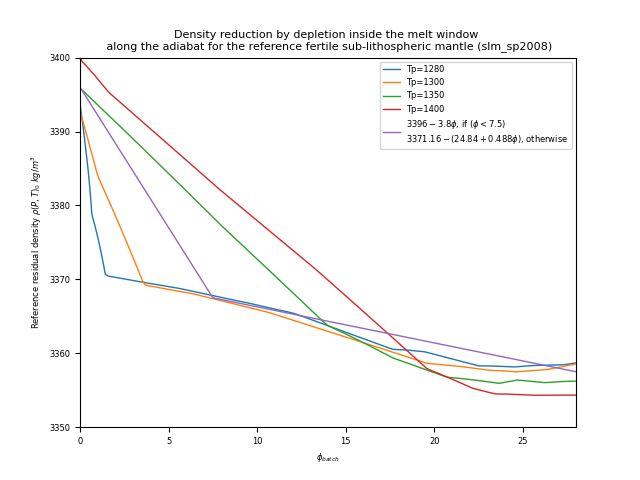

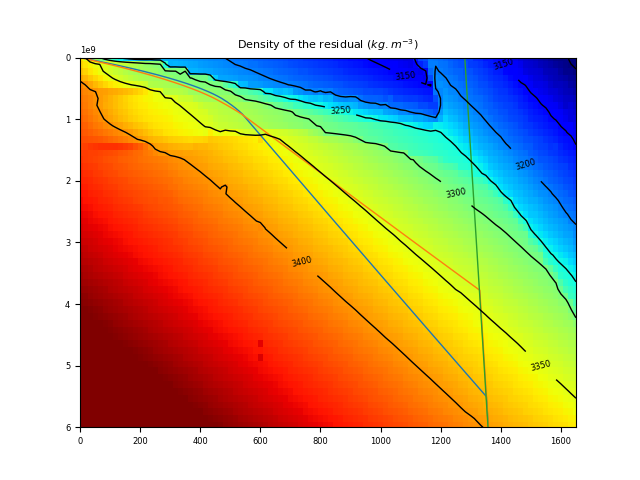

In [4]:
# Relationship between density of the residual and melt fraction for the reference fertile sub-lithospheric mantle
#
# Toward an estimate of the density reduction by depletion inside the melt window 
# along the adiabat for the reference fertile sub-lithospheric mantle
# 
# Important remark:
# - Neither rho nor rhoresidual is used in the melt window to compute the density in the 2-D geodynamic code
# - We use equation (6) to compute rho(T,P)_0 = 3396 + delta_rho_X(phi)
# (see below and also explanations in the paper and supplemental figure S11)
#

lith_name    = 'ridge_NoOc_NoDiffLayer'
name         = 'slm_sp2008'
path_used    = path+name

# Display reference geotherms

%matplotlib widget

read_perplex = geodyn1d.thermodyn.read_binary_file_perplex(name,path=path_used)
geodyn1d.visualization.plot_table(read_perplex,
                                  data='rhoresidual',
                                  ylim=[0,6e9],vmin=3100,vmax=3500,
                                  display_contour=True,
                                  geotherms=True,
                                  colorbar=None,
                                  lithospheres=['lith180','lith125',lith_name])

# Load data
lith1    = geodyn1d.lithosphere(lith_name)
perplex  = geodyn1d.thermodyn.read_binary_file_perplex(name,path=path_used)

# Compute reference density (correction of the effect of temperature and pressure on densities)
perplex.rho   = perplex.rhoresidual
perplex.alpha = perplex.alpharesidual
perplex.beta  = perplex.betaresidual
rho_ref_value, rho_ref_std, rho_ref = geodyn1d.thermodyn.compute_rho_ref_perplex(perplex,domainBased=False,lithos=lith1)

melt    = deepcopy(perplex.melt)
rho_ref = rho_ref[melt>1e-4]
melt    = melt[melt>1e-4]*100

# Compute and plot density of the residual versus melt fraction varying mantle temperature (1280-1400)
#
plt.figure()
sort_melt, sort_rhoref = compute_rhoref_along_geotherm(perplex,lithos=lith1)
plt.plot(sort_melt,sort_rhoref,label='Tp=1280')
sort_melt, sort_rhoref = compute_rhoref_along_geotherm(perplex,lithos=lith1,temperature_shift=20)
plt.plot(sort_melt,sort_rhoref,label='Tp=1300')
sort_melt, sort_rhoref = compute_rhoref_along_geotherm(perplex,lithos=lith1,temperature_shift=70)
plt.plot(sort_melt,sort_rhoref,label='Tp=1350')
sort_melt, sort_rhoref = compute_rhoref_along_geotherm(perplex,lithos=lith1,temperature_shift=120)
plt.plot(sort_melt,sort_rhoref,label='Tp=1400')

# Plot model used in this study
#
phi            = np.linspace(0,100,10000)
rhoref_model_1 = 3396 - 3.8*phi[phi<7.5] # phi < 7.5
rhoref_model_2 = 3371.16 - 0.487805*phi[phi>=7.5] # phi >= 7.5
rhoref_model   = np.concatenate((rhoref_model_1,rhoref_model_2),axis=None)
plt.plot(phi,rhoref_model,
         label=r'$3396-3.8\phi$'+", if ("+r'$\phi<7.5$'+")\n"+
               r'$3371.16-(24.84 + 0.488\phi)$'+", otherwise")

plt.ylabel(r'Reference residual density $\rho(P,T)_{0}$ $kg/m^{3}$')
plt.xlim([0,28])
plt.ylim([3350,3400])
plt.xlabel('$\phi_{batch}$')
plt.title('Density reduction by depletion inside the melt window \n along the adiabat for the reference fertile sub-lithospheric mantle ('+name+')')
plt.legend()
plt.show()

In [5]:
# Building file to be used with fantom 
# 1) Construction of a binary file without melt
# 2) Construction of a composite file that should be used with FANTOM

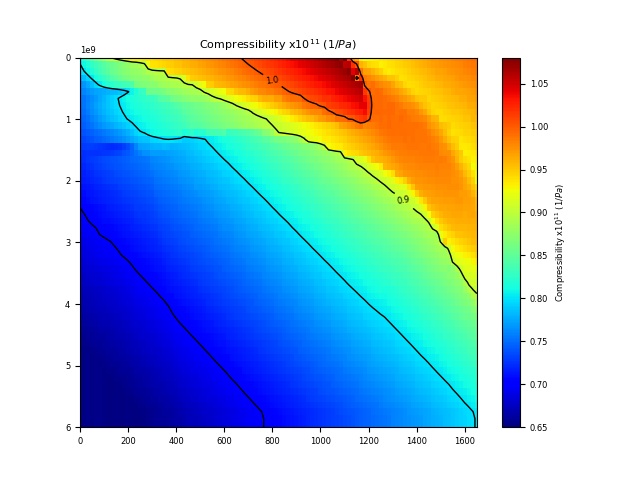

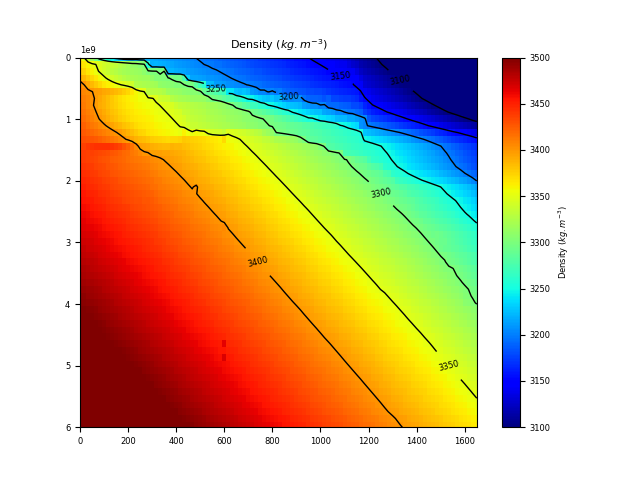

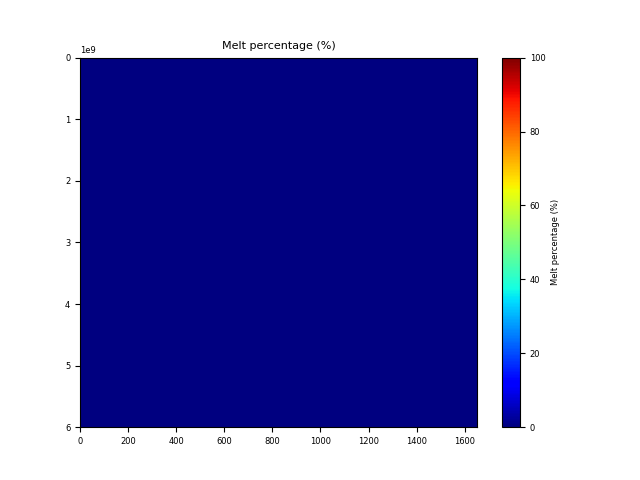

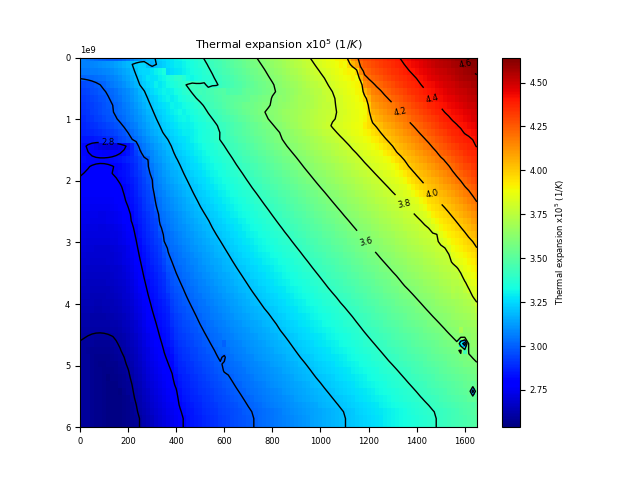

In [8]:
# 1) Construction of a binary file without melt

finalmelt_percent = -1
plotcontrol       = True

if (finalmelt_percent == -1):
    suffix = '_no_melt'
else:
    suffix = '_'+str(finalmelt_percent)+'max_melt'

name = 'slm_sp2008'  # = correct new version of 'mg89_high_al2o3_high_na2o_Cr'
#name = 'plm1'
#name = 'mg93_low_al2o3_low_na2o_Cr'
#name = 'plm2'
#name = 'mg89_low_al2o3_low_na2o_Cr'
#name = 'alm0'
#name = 'ylm3'

path_used = path+name

read_perplex = geodyn1d.thermodyn.read_binary_file_perplex(name,path=path_used)
geodyn1d.thermodyn.remove_melt_from_perplex(read_perplex,melt_percent=finalmelt_percent)
geodyn1d.thermodyn.write_binary_file_perplex(read_perplex,name+suffix,path=path_used)
geodyn1d.thermodyn.write_binary_fortran_file_perplex(read_perplex,name+suffix,path=path_used)

if ( plotcontrol ):
    read_perplex = geodyn1d.thermodyn.read_binary_file_perplex(name+suffix,path=path_used)
    geodyn1d.visualization.plot_table(read_perplex,data='rho',ylim=[0,6e9],vmin=3100,vmax=3500,colorbar="left",display_contour=True)
    geodyn1d.visualization.plot_table(read_perplex,data='melt',ylim=[0,6e9],vmin=0,vmax=100,colorbar="left",display_contour=True)
    geodyn1d.visualization.plot_table(read_perplex,data='alpha',ylim=[0,6e9],colorbar="left",display_contour=True)
    geodyn1d.visualization.plot_table(read_perplex,data='beta',ylim=[0,6e9],colorbar="left",display_contour=True)
    #geodyn1d.visualization.plot_table(read_perplex,data='beta',ylim=[0,6e9],colorbar="left",display_contour=True)
    plt.show()
    
    
    

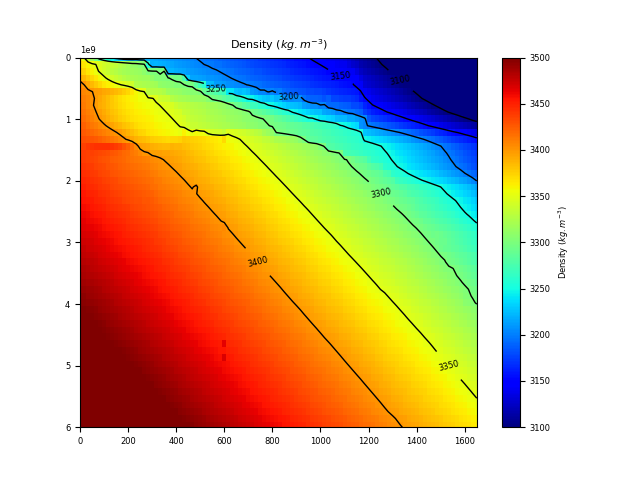

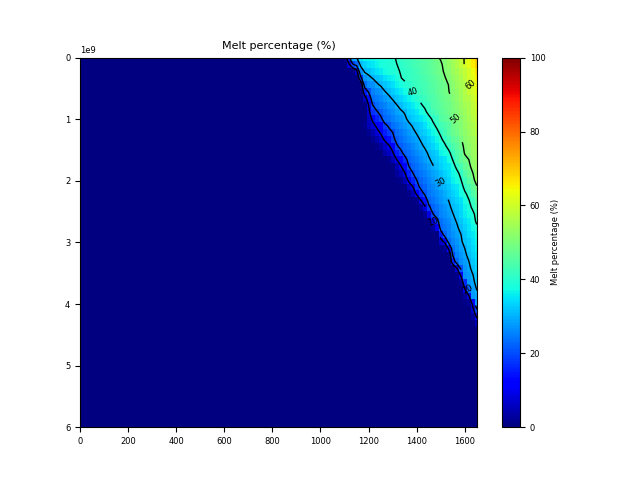

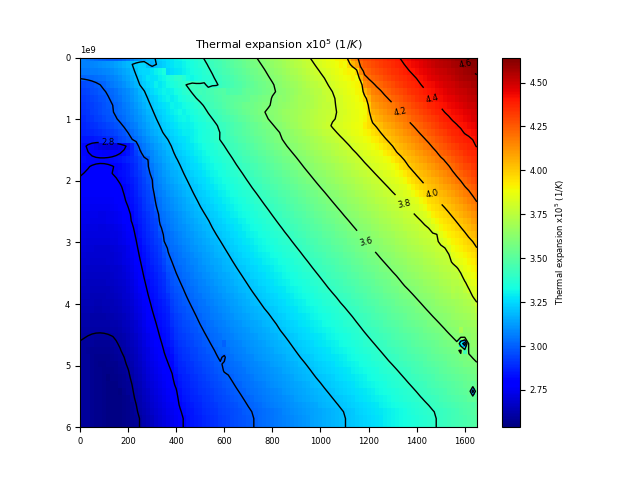

In [10]:
# 2) Construction of a composite file that should be used with FANTOM
# Only reason for this is that sub-solidus densities are extrapolated 
# inside the melt window in case someone would like to use density table without feedback from melting on density
# REM: this option has never been used now as melting must be considered in any cases

building    = True
plotcontrol = True
pmax        = 22.0e9
suffix      = '_no_melt_composite'

#name         = 'mg89_high_al2o3_high_na2o_Cr'
#name_no_melt = 'mg89_high_al2o3_high_na2o_Cr_no_melt'

name         = 'slm_sp2008'
name_no_melt = 'slm_sp2008_no_melt'

#name         = 'mg89_low_al2o3_low_na2o_Cr'
#name_no_melt = 'mg89_low_al2o3_low_na2o_Cr_no_melt'

#name         = 'mg93_low_al2o3_low_na2o_Cr'
#name_no_melt = 'mg93_low_al2o3_low_na2o_Cr_no_melt'

#name         = 'mg93_high_al2o3_high_na2o_Cr'
#name_no_melt = 'mg93_high_al2o3_high_na2o_Cr_no_melt'

#name         = 'plm1'
#name_no_melt = 'plm1_no_melt'

#name         = 'plm2'
#name_no_melt = 'plm2_no_melt'

#name         = 'mg89_low_al2o3_low_na2o_Cr'
#name_no_melt = 'mg89_low_al2o3_low_na2o_Cr_no_melt'

#name         = 'alm0'
#name_no_melt = 'alm0_no_melt'

#name         = 'ylm3'
#name_no_melt = 'ylm3_no_melt'

path_used = path+name

if (building):
    read_perplex         = geodyn1d.thermodyn.read_binary_file_perplex(name,path=path_used)
    read_perplex_no_melt = geodyn1d.thermodyn.read_binary_file_perplex(name_no_melt,path=path_used)
    read_perplex.rho     = read_perplex_no_melt.rho
    read_perplex.alpha   = read_perplex_no_melt.alpha
    read_perplex.beta    = read_perplex_no_melt.beta
    geodyn1d.thermodyn.write_binary_file_perplex(read_perplex,name+suffix,path=path_used)
    geodyn1d.thermodyn.write_binary_fortran_file_perplex(read_perplex,name+suffix,path=path_used)

if ( plotcontrol ):
    read_perplex = geodyn1d.thermodyn.read_binary_file_perplex(name+suffix,path=path_used)
    geodyn1d.visualization.plot_table(read_perplex,data='rho',ylim=[0,6e9],vmin=3100,vmax=3500,colorbar="left",display_contour=True)
    geodyn1d.visualization.plot_table(read_perplex,data='melt',ylim=[0,6e9],vmin=0,vmax=100,colorbar="left",display_contour=True)
    geodyn1d.visualization.plot_table(read_perplex,data='alpha',ylim=[0,6e9],colorbar="left",display_contour=True)    
    